### In this notebook we will continue to explore the data and create new features we can use during modeling. Since the data only contains the longitude/latitude values, we need to create a way to measure the distance traveled. 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import geopy.distance
import h3
import haversine

In [13]:
#read data
bike = pd.read_csv('bike_preprocessed.csv')

#### Descriptive statistics of the ride lengths after removing observations in the previous notebook. The mean is around 1000 while the median is about 800 seconds. The distribution's spread can be measured by the standard deviation which is about 700 seconds. 

In [14]:
bike.ride_length_seconds.describe()

count    3.161357e+06
mean     1.004570e+03
std      6.965471e+02
min      5.600000e+01
25%      4.640000e+02
50%      8.130000e+02
75%      1.390000e+03
max      3.306000e+03
Name: ride_length_seconds, dtype: float64

### We will try to create a feature that determines if a ride took place with a friend. Since the rides are ordered by start time by default, we will do this by measuring the time between consectutive rides and see if the start and end stations are the same for these observations. 

In [19]:
bike['Time_diff']=np.abs(pd.to_datetime(bike['start_time'].astype(str)).diff(-1).dt.total_seconds())

In [20]:
bike['with_friend']=np.nan

In [21]:
bike.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,end_lng,member_casual,start_time,end_time,ride_length,start_date1,week_day,ride_length_seconds,Time_diff,with_friend
0,74346,5DB63F4E4EB6A9CF,docked_bike,2020-04-01 00:00:30,2020-04-01 00:23:03,Damen Ave & Wellington Ave,162,Pine Grove Ave & Waveland Ave,232.0,41.9359,...,-87.6463,casual,2020-04-01 00:00:30,2020-04-01 00:23:03,0 days 00:22:33,2020-04-01 00:00:00,Tuesday,1353.0,125.0,NaN
1,46139,1FD159E93F7BAFA1,docked_bike,2020-04-01 00:02:35,2020-04-01 00:10:45,Wabash Ave & 16th St,72,Wabash Ave & 9th St,321.0,41.8604,...,-87.6257,member,2020-04-01 00:02:35,2020-04-01 00:10:45,0 days 00:08:10,2020-04-01 00:00:00,Tuesday,490.0,6.0,NaN
2,17735,6D93A270684EC452,docked_bike,2020-04-01 00:02:41,2020-04-01 00:24:20,Damen Ave & Wellington Ave,162,Spaulding Ave & Armitage Ave,506.0,41.9359,...,-87.7102,casual,2020-04-01 00:02:41,2020-04-01 00:24:20,0 days 00:21:39,2020-04-01 00:00:00,Tuesday,1299.0,243.0,NaN
3,53075,091D47E4F0FC5022,docked_bike,2020-04-01 00:06:44,2020-04-01 00:14:01,Mies van der Rohe Way & Chicago Ave,173,Clark St & Schiller St,301.0,41.8969,...,-87.6315,member,2020-04-01 00:06:44,2020-04-01 00:14:01,0 days 00:07:17,2020-04-01 00:00:00,Tuesday,437.0,412.0,NaN
4,55022,643593E85E46A45C,docked_bike,2020-04-01 00:13:36,2020-04-01 00:18:59,Kingsbury St & Erie St,74,Larrabee St & Division St,359.0,41.8938,...,-87.6434,member,2020-04-01 00:13:36,2020-04-01 00:18:59,0 days 00:05:23,2020-04-01 00:00:00,Tuesday,323.0,5.0,NaN


### Looping through the whole dataset (3 million+ obs) take takes a very long time when when we don't split up the data set. I'm not sure why this happens, but it is drastically faster when we split up the data. 

In [26]:
b0,b1,b2,b3,b4,b5,b6,b7,b8,b9=np.array_split(bike,10)

In [27]:
def with_friend(mydata):
    i=0
    for i in range(len(mydata)-1):
        # if time difference is less than 25 and same start and end stations then with_friends=1
        if mydata.iloc[i,20]<=25 and mydata.iloc[i,6]==mydata.iloc[i+1,6] and mydata.iloc[i,8]==mydata.iloc[i+1,8]:
            mydata.iloc[i,21]=1
            mydata.iloc[i+1,21]=1
            i=i+1
        elif mydata.iloc[i,21]==1:
            i=i+1
        else:
            mydata.iloc[i,21]=0
            i=i+1

In [28]:
with_friend(b0)
with_friend(b1)
with_friend(b2)
with_friend(b3)
with_friend(b4)
with_friend(b5)
with_friend(b6)
with_friend(b7)
with_friend(b8)
with_friend(b9)

In [29]:
bike = pd.concat([b0,b1,b2,b3,b4,b5,b6,b7,b8,b9])

In [34]:
#number of rides that happened with friends
bike.with_friend.sum()

106676.0

In [35]:
#bike.to_csv('bike_friend.csv', index=False)

In [2]:
#bike = pd.read_csv('bike_friend.csv')

/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
bike.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,end_lng,member_casual,start_time,end_time,ride_length,start_date1,week_day,ride_length_seconds,Time_diff,with_friend
0,74346,5DB63F4E4EB6A9CF,docked_bike,2020-04-01 00:00:30,2020-04-01 00:23:03,Damen Ave & Wellington Ave,162,Pine Grove Ave & Waveland Ave,232.0,41.9359,...,-87.6463,casual,2020-04-01 00:00:30,2020-04-01 00:23:03,0 days 00:22:33,2020-04-01 00:00:00,Tuesday,1353.0,125.0,0.0
1,46139,1FD159E93F7BAFA1,docked_bike,2020-04-01 00:02:35,2020-04-01 00:10:45,Wabash Ave & 16th St,72,Wabash Ave & 9th St,321.0,41.8604,...,-87.6257,member,2020-04-01 00:02:35,2020-04-01 00:10:45,0 days 00:08:10,2020-04-01 00:00:00,Tuesday,490.0,6.0,0.0
2,17735,6D93A270684EC452,docked_bike,2020-04-01 00:02:41,2020-04-01 00:24:20,Damen Ave & Wellington Ave,162,Spaulding Ave & Armitage Ave,506.0,41.9359,...,-87.7102,casual,2020-04-01 00:02:41,2020-04-01 00:24:20,0 days 00:21:39,2020-04-01 00:00:00,Tuesday,1299.0,243.0,0.0
3,53075,091D47E4F0FC5022,docked_bike,2020-04-01 00:06:44,2020-04-01 00:14:01,Mies van der Rohe Way & Chicago Ave,173,Clark St & Schiller St,301.0,41.8969,...,-87.6315,member,2020-04-01 00:06:44,2020-04-01 00:14:01,0 days 00:07:17,2020-04-01 00:00:00,Tuesday,437.0,412.0,0.0
4,55022,643593E85E46A45C,docked_bike,2020-04-01 00:13:36,2020-04-01 00:18:59,Kingsbury St & Erie St,74,Larrabee St & Division St,359.0,41.8938,...,-87.6434,member,2020-04-01 00:13:36,2020-04-01 00:18:59,0 days 00:05:23,2020-04-01 00:00:00,Tuesday,323.0,5.0,1.0


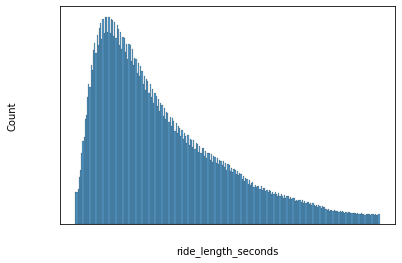

In [4]:
sns.histplot(x=bike["ride_length_seconds"]).tick_params(axis='both', colors='white')

In [5]:
bike.ride_length_seconds.describe()

count    3.161357e+06
mean     1.004570e+03
std      6.965471e+02
min      5.600000e+01
25%      4.640000e+02
50%      8.130000e+02
75%      1.390000e+03
max      3.306000e+03
Name: ride_length_seconds, dtype: float64

### Next we will categorize the ride lengths as short, medium, and long based on the ride lengths. We choose Q1,Q2,and Q3 as the cut off points for the categories. 

In [6]:
bike.loc[bike['ride_length_seconds'] <=464, 'ride_type'] = 'short'
bike.loc[bike['ride_length_seconds'] >464 , 'ride_type'] = 'medium'
bike.loc[bike['ride_length_seconds'] >=1390, 'ride_type'] = 'long'

In [7]:
bike.ride_type.value_counts()

medium    1581677
long       790953
short      788727
Name: ride_type, dtype: int64

In [8]:
bike.groupby("ride_type")["with_friend"].mean()

ride_type
long      0.052469
medium    0.032000
short     0.018464
Name: with_friend, dtype: float64

#### Long rides have much more riders who are with friend (about 5%) than the other type (3.2% and 1.8%)

In [9]:
#means of ride lengths by group
bike.groupby("ride_type")["ride_length_seconds"].mean().sort_values(ascending=False)

ride_type
long      2013.568604
medium     849.153163
short      304.389056
Name: ride_length_seconds, dtype: float64

In [10]:
#Saturday and Fridays have the longest average ride times. All other days have ride times under 1000 seconds.
bike.groupby("week_day")["ride_length_seconds"].mean().sort_values(ascending=False)

week_day
Saturday     1118.645198
Friday       1113.470347
Thursday      979.250812
Sunday        957.799117
Wednesday     939.847938
Monday        935.835832
Tuesday       934.566044
Name: ride_length_seconds, dtype: float64

In [11]:
#The weekends have the largest percentage of rides that occur with friends
bike.groupby("week_day")["with_friend"].mean().sort_values(ascending=False)

week_day
Saturday     0.048981
Friday       0.047828
Thursday     0.031725
Sunday       0.028488
Wednesday    0.025500
Tuesday      0.023701
Monday       0.022980
Name: with_friend, dtype: float64

### Since we have such a large sample size, it seems pointless to do a test for significant difference between means. All tests with such large sample sizes will have significant p-values

### Categorize as weekday/weekend based on the above statistics for the days. It seems like rides on Thursday, Friday, Saturday have very similar characteristics. 

In [26]:
conditions = [
    bike.week_day.eq('Monday') | bike.week_day.eq('Tuesday') | bike.week_day.eq('Wednesday') | bike.week_day.eq('Sunday') 
]

In [27]:
bike['weekend_weekday'] = np.select(conditions, [0], default=1)

In [20]:
bike.head(10)

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,start_time,end_time,ride_length,start_date1,week_day,ride_length_seconds,Time_diff,with_friend,ride_type,weekend_weekday
0,74346,5DB63F4E4EB6A9CF,docked_bike,2020-04-01 00:00:30,2020-04-01 00:23:03,Damen Ave & Wellington Ave,162,Pine Grove Ave & Waveland Ave,232.0,41.9359,...,2020-04-01 00:00:30,2020-04-01 00:23:03,0 days 00:22:33,2020-04-01 00:00:00,Tuesday,1353.0,125.0,0.0,medium,0
1,46139,1FD159E93F7BAFA1,docked_bike,2020-04-01 00:02:35,2020-04-01 00:10:45,Wabash Ave & 16th St,72,Wabash Ave & 9th St,321.0,41.8604,...,2020-04-01 00:02:35,2020-04-01 00:10:45,0 days 00:08:10,2020-04-01 00:00:00,Tuesday,490.0,6.0,0.0,medium,0
2,17735,6D93A270684EC452,docked_bike,2020-04-01 00:02:41,2020-04-01 00:24:20,Damen Ave & Wellington Ave,162,Spaulding Ave & Armitage Ave,506.0,41.9359,...,2020-04-01 00:02:41,2020-04-01 00:24:20,0 days 00:21:39,2020-04-01 00:00:00,Tuesday,1299.0,243.0,0.0,medium,0
3,53075,091D47E4F0FC5022,docked_bike,2020-04-01 00:06:44,2020-04-01 00:14:01,Mies van der Rohe Way & Chicago Ave,173,Clark St & Schiller St,301.0,41.8969,...,2020-04-01 00:06:44,2020-04-01 00:14:01,0 days 00:07:17,2020-04-01 00:00:00,Tuesday,437.0,412.0,0.0,short,0
4,55022,643593E85E46A45C,docked_bike,2020-04-01 00:13:36,2020-04-01 00:18:59,Kingsbury St & Erie St,74,Larrabee St & Division St,359.0,41.8938,...,2020-04-01 00:13:36,2020-04-01 00:18:59,0 days 00:05:23,2020-04-01 00:00:00,Tuesday,323.0,5.0,1.0,short,0
5,14551,782CEA3C6968D2A6,docked_bike,2020-04-01 00:13:41,2020-04-01 00:19:09,Kingsbury St & Erie St,74,Larrabee St & Division St,359.0,41.8938,...,2020-04-01 00:13:41,2020-04-01 00:19:09,0 days 00:05:28,2020-04-01 00:00:00,Tuesday,328.0,493.0,1.0,short,0
6,6131,432C76DCFB84366A,docked_bike,2020-04-01 00:21:54,2020-04-01 00:27:20,Sheridan Rd & Irving Park Rd,240,Pine Grove Ave & Irving Park Rd,254.0,41.9542,...,2020-04-01 00:21:54,2020-04-01 00:27:20,0 days 00:05:26,2020-04-01 00:00:00,Tuesday,326.0,118.0,0.0,short,0
7,1788,7912522A5308E3DA,docked_bike,2020-04-01 00:23:52,2020-04-01 00:34:42,California Ave & Altgeld St,502,Southport Ave & Clybourn Ave,307.0,41.9267,...,2020-04-01 00:23:52,2020-04-01 00:34:42,0 days 00:10:50,2020-04-01 00:00:00,Tuesday,650.0,929.0,0.0,medium,0
8,65110,545019BF3EF4B419,docked_bike,2020-04-01 00:39:21,2020-04-01 00:43:19,Blue Island Ave & 18th St,129,Morgan St & 18th St,14.0,41.8576,...,2020-04-01 00:39:21,2020-04-01 00:43:19,0 days 00:03:58,2020-04-01 00:00:00,Tuesday,238.0,378.0,0.0,short,0
9,70959,5283BF7DA7BC511C,docked_bike,2020-04-01 00:45:39,2020-04-01 00:56:58,Clark St & Elm St,176,Clinton St & Madison St,77.0,41.9030,...,2020-04-01 00:45:39,2020-04-01 00:56:58,0 days 00:11:19,2020-04-01 00:00:00,Tuesday,679.0,1510.0,0.0,medium,0


In [28]:
#relationship between friends and ride length
bike.with_friend.corr(bike.ride_length_seconds)

0.07066326608048511

In [29]:
#relationship between weekend (thursday, friday, saturday) and weekday (Sunday, Monday, Tues, Wed), longer rides on weekends
bike.weekend_weekday.corr(bike.ride_length_seconds)

0.09427664638871085

In [35]:
bike["time_only"]=pd.to_datetime(bike.start_time).dt.time

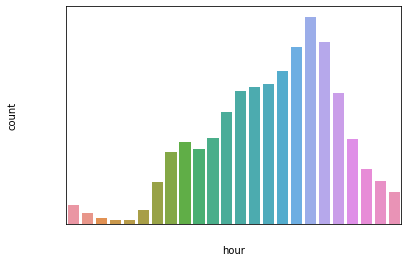

In [51]:
bike["hour"]=pd.to_datetime(bike.start_time).dt.hour
sns.countplot(x=bike['hour']).tick_params(axis='both', colors='white')

### people seem to start waking up at 5am the earliest
### Noon should be cutoff for moring, and 5pm cutoff for night

In [61]:
bike.loc[bike['time_only'] <=datetime.time(5), 'time_of_day'] = 'night'
bike.loc[bike['time_only'] > datetime.time(5), 'time_of_day'] = 'morning'
bike.loc[bike['time_only'] > datetime.time(11,30), 'time_of_day'] = 'afternoon'
bike.loc[bike['time_only'] > datetime.time(16,45), 'time_of_day'] = 'night'

In [200]:
bike.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,week_day,ride_length_seconds,Time_diff,with_friend,ride_type,weekend_weekday,time_only,hour,time_of_day,Dist
0,74346,5DB63F4E4EB6A9CF,docked_bike,2020-04-01 00:00:30,2020-04-01 00:23:03,Damen Ave & Wellington Ave,162,Pine Grove Ave & Waveland Ave,232.0,41.9359,...,Tuesday,1353.0,125.0,0.0,medium,0,00:00:30,0,night,3.044482
1,46139,1FD159E93F7BAFA1,docked_bike,2020-04-01 00:02:35,2020-04-01 00:10:45,Wabash Ave & 16th St,72,Wabash Ave & 9th St,321.0,41.8604,...,Tuesday,490.0,6.0,0.0,medium,0,00:02:35,0,night,1.155164851339179 km
2,17735,6D93A270684EC452,docked_bike,2020-04-01 00:02:41,2020-04-01 00:24:20,Damen Ave & Wellington Ave,162,Spaulding Ave & Armitage Ave,506.0,41.9359,...,Tuesday,1299.0,243.0,0.0,medium,0,00:02:41,0,night,3.364186434699514 km
3,53075,091D47E4F0FC5022,docked_bike,2020-04-01 00:06:44,2020-04-01 00:14:01,Mies van der Rohe Way & Chicago Ave,173,Clark St & Schiller St,301.0,41.8969,...,Tuesday,437.0,412.0,0.0,short,0,00:06:44,0,night,1.4769155444993292 km
4,55022,643593E85E46A45C,docked_bike,2020-04-01 00:13:36,2020-04-01 00:18:59,Kingsbury St & Erie St,74,Larrabee St & Division St,359.0,41.8938,...,Tuesday,323.0,5.0,1.0,short,0,00:13:36,0,night,1.0865880720236594 km


### Next we will use the start/end locations to calculate distance traveled. We will calculate the distance between these points, and not neccesarily the distance traveled. For longer distances these will be a better estiamte than for shorter rides. 

In [73]:
#calculate distance traveled
bike.loc[:,"start_lat":"end_lng"]

,start_lat,start_lng,end_lat,end_lng
0,41.935900,-87.678400,41.949300,-87.646300
1,41.860400,-87.625800,41.870800,-87.625700
2,41.935900,-87.678400,41.917100,-87.710200
3,41.896900,-87.621700,41.908000,-87.631500
4,41.893800,-87.641700,41.903500,-87.643400
...,...,...,...,...
3161352,41.864059,-87.623727,41.858166,-87.656495
3161353,41.867087,-87.641014,41.915945,-87.677218
3161354,41.893992,-87.629318,41.961004,-87.649603
3161355,41.967096,-87.667429,41.967096,-87.667429


In [76]:
#bike.to_csv('bike_newest.csv', index=False)

In [3]:
#bike = pd.read_csv('bike_newest.csv')

/Users/user/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [172]:
#end lat and lng has some missing values
bike.columns[bike.isnull().any()]

Index(['start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'end_lat', 'end_lng', 'Time_diff', 'with_friend'],
      dtype='object')

In [4]:
#haversine package is easy to use and returns a float
coords_1 = (41.935900, -87.678400)
coords_2 = (41.949300, -87.646300)

haversine.haversine(coords_1, coords_2)

3.044482089761593

In [85]:
#missing values error
bike['Dist'] = bike.apply(lambda row: geopy.distance.geodesic((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis=1)

ValueError: Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.

In [5]:
bike_mod= bike.dropna( how='any',subset=['end_lat', 'end_lat'])

In [203]:
#about 2 thousand observations missing end latitude and longitude
print(len(bike_mod))
print(len(bike))

3159290
3161357


In [206]:
bike_mod[bike_mod['end_lat'].isnull()]

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,start_date1,week_day,ride_length_seconds,Time_diff,with_friend,ride_type,weekend_weekday,time_only,hour,time_of_day


In [6]:
#split to reduce runtime
b0,b1,b2,b3,b4=np.array_split(bike_mod,5)

In [7]:
b0['Dist'] = b0.apply(lambda row: haversine.haversine((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis=1)
b1['Dist'] = b1.apply(lambda row: haversine.haversine((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis=1)
b2['Dist'] = b2.apply(lambda row: haversine.haversine((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis=1)
b3['Dist'] = b3.apply(lambda row: haversine.haversine((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis=1)
b4['Dist'] = b4.apply(lambda row: haversine.haversine((row['start_lat'], row['start_lng']), (row['end_lat'], row['end_lng'])), axis=1)

In [8]:
bike_mod = pd.concat([b0,b1,b2,b3,b4])

In [9]:
#we will use the new data since so few obs were removed. It might have been an error as well
bike=bike_mod

In [10]:
bike.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,week_day,ride_length_seconds,Time_diff,with_friend,ride_type,weekend_weekday,time_only,hour,time_of_day,Dist
0,74346,5DB63F4E4EB6A9CF,docked_bike,2020-04-01 00:00:30,2020-04-01 00:23:03,Damen Ave & Wellington Ave,162,Pine Grove Ave & Waveland Ave,232.0,41.9359,...,Tuesday,1353.0,125.0,0.0,medium,0,00:00:30,0,night,3.044482
1,46139,1FD159E93F7BAFA1,docked_bike,2020-04-01 00:02:35,2020-04-01 00:10:45,Wabash Ave & 16th St,72,Wabash Ave & 9th St,321.0,41.8604,...,Tuesday,490.0,6.0,0.0,medium,0,00:02:35,0,night,1.156458
2,17735,6D93A270684EC452,docked_bike,2020-04-01 00:02:41,2020-04-01 00:24:20,Damen Ave & Wellington Ave,162,Spaulding Ave & Armitage Ave,506.0,41.9359,...,Tuesday,1299.0,243.0,0.0,medium,0,00:02:41,0,night,3.360229
3,53075,091D47E4F0FC5022,docked_bike,2020-04-01 00:06:44,2020-04-01 00:14:01,Mies van der Rohe Way & Chicago Ave,173,Clark St & Schiller St,301.0,41.8969,...,Tuesday,437.0,412.0,0.0,short,0,00:06:44,0,night,1.476895
4,55022,643593E85E46A45C,docked_bike,2020-04-01 00:13:36,2020-04-01 00:18:59,Kingsbury St & Erie St,74,Larrabee St & Division St,359.0,41.8938,...,Tuesday,323.0,5.0,1.0,short,0,00:13:36,0,night,1.087731


(0.0, 250000.0)

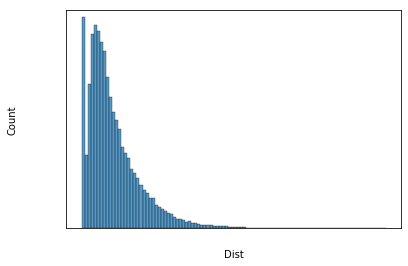

In [229]:
sns.histplot(data=bike,x="Dist",bins=100).tick_params(axis='both', colors='white')
plt.ylim(0,250000)

### The distance plot shows a lot of rides to have small distances, which is likely a resulted of a bug or the riders changing their mind. We should remove these observations since these are rides we are not interested in.

In [233]:
#cutoff set as 15 feet
zero_dist=bike[bike.Dist<0.004572]

In [234]:
zero_dist

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,week_day,ride_length_seconds,Time_diff,with_friend,ride_type,weekend_weekday,time_only,hour,time_of_day,Dist
13,8857,948FF22F1350EEB4,docked_bike,2020-04-01 02:34:36,2020-04-01 02:47:43,Michigan Ave & Madison St,197,Michigan Ave & Madison St,197.0,41.882100,...,Tuesday,787.0,1858.0,0.0,medium,0,02:34:36,2,night,0.0
16,15165,C070E17FD3115E05,docked_bike,2020-04-01 03:41:08,2020-04-01 04:14:22,Southport Ave & Belmont Ave,154,Southport Ave & Belmont Ave,154.0,41.939500,...,Tuesday,1994.0,146.0,0.0,long,0,03:41:08,3,night,0.0
17,4271,71AFDB68CD4B2F10,docked_bike,2020-04-01 03:43:34,2020-04-01 03:52:19,Emerald Ave & 28th St,207,Emerald Ave & 28th St,207.0,41.843600,...,Tuesday,525.0,1246.0,0.0,medium,0,03:43:34,3,night,0.0
33,40314,E03011DECFF9F706,docked_bike,2020-04-01 05:41:12,2020-04-01 06:17:44,Broadway & Wilson Ave,293,Broadway & Wilson Ave,293.0,41.965200,...,Tuesday,2192.0,163.0,0.0,long,0,05:41:12,5,morning,0.0
38,38008,455207675E6BC95B,docked_bike,2020-04-01 05:54:06,2020-04-01 06:16:02,Damen Ave & Foster Ave,464,Damen Ave & Foster Ave,464.0,41.975600,...,Tuesday,1316.0,11.0,0.0,medium,0,05:54:06,5,morning,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161258,3360108,80840C9BD73F0BF7,electric_bike,2021-03-31 22:44:35,2021-03-31 22:46:47,NaN,NaN,NaN,NaN,41.800000,...,Tuesday,132.0,12.0,0.0,short,0,22:44:35,22,night,0.0
3161270,3340723,231AF0EDDDCD74E4,classic_bike,2021-03-31 22:53:22,2021-03-31 23:23:20,Woodlawn Ave & 55th St,TA1307000164,Woodlawn Ave & 55th St,TA1307000164,41.795264,...,Tuesday,1798.0,29.0,0.0,long,0,22:53:22,22,night,0.0
3161288,3481642,BDA37CA60AFF84C3,classic_bike,2021-03-31 23:05:04,2021-03-31 23:48:20,Fairbanks Ct & Grand Ave,TA1305000003,Fairbanks Ct & Grand Ave,TA1305000003,41.891847,...,Tuesday,2596.0,32.0,0.0,long,0,23:05:04,23,night,0.0
3161297,3472401,5DA130B20593658D,electric_bike,2021-03-31 23:09:50,2021-03-31 23:15:59,NaN,NaN,NaN,NaN,41.790000,...,Tuesday,369.0,78.0,0.0,short,0,23:09:50,23,night,0.0


In [232]:
max(zero_dist.Dist)

8.560077152995924e-06

In [237]:
zero_dist.Time_diff.describe()

count    217415.000000
mean         11.191252
std         118.726774
min           0.000000
25%           1.000000
50%           3.000000
75%           9.000000
max       36309.000000
Name: Time_diff, dtype: float64

In [238]:
bike.Dist.describe()

count    3.159290e+06
mean     2.274282e+00
std      1.874718e+00
min      0.000000e+00
25%      9.782873e-01
50%      1.776169e+00
75%      3.112548e+00
max      2.238865e+01
Name: Dist, dtype: float64

In [239]:
zero_dist.time_of_day.value_counts()

night        106363
afternoon     77053
morning       33999
Name: time_of_day, dtype: int64

In [240]:
zero_dist.week_day.value_counts()

Friday       39834
Saturday     38015
Thursday     29761
Wednesday    27850
Tuesday      27627
Sunday       27624
Monday       26704
Name: week_day, dtype: int64

### Instead of using distance, we'll use distance relative to time (speed) to remove unreasonable observations.

In [11]:
bike["ride_length_hours"] = bike.ride_length_seconds/3600

In [14]:
bike["speed_kmh"] = bike.Dist/bike.ride_length_hours

In [17]:
bike.speed_kmh.describe()
#distribution is skewed to the left

count    3.159290e+06
mean     9.416154e+00
std      4.768820e+00
min      0.000000e+00
25%      6.829908e+00
50%      9.934790e+00
75%      1.250241e+01
max      3.650359e+02
Name: speed_kmh, dtype: float64

In [23]:
bike_mod=bike[bike.speed_kmh<30]

(0.0, 100000.0)

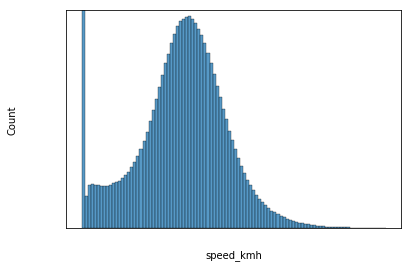

In [27]:
sns.histplot(data=bike_mod,x="speed_kmh",bins=100).tick_params(axis='both', colors='white')
plt.ylim(0,100000)

### From online reasearch, seems like commuters (advanced riders) average around 10-15 mph (16-24 kph) but we should expect casual riders in the city riding in traffic to do around 8-12 mph. We'll choose our limits to be 5 kph (walking speed) and 22 kph (advanced speed) as our cutoffs

In [30]:
bike_mod = bike[bike.speed_kmh<22]
bike_mod = bike_mod[bike.speed_kmh>5]

<ipython-input-30-670333c708e3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bike_mod = bike_mod[bike.speed_kmh>5]


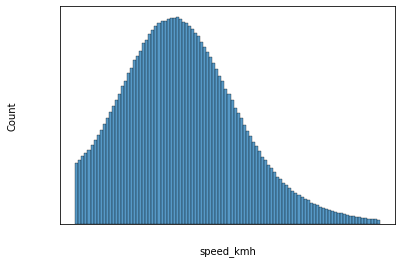

In [31]:
sns.histplot(data=bike_mod,x="speed_kmh",bins=100).tick_params(axis='both', colors='white')

In [35]:
len(bike_mod)
#500000 obs removed

2587878

(0.0, 250000.0)

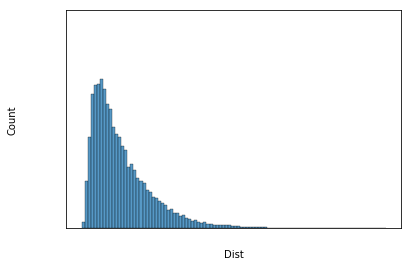

In [36]:
sns.histplot(data=bike_mod,x="Dist",bins=100).tick_params(axis='both', colors='white')
plt.ylim(0,250000)

In [37]:
bike_mod.Dist.describe()
#minimum distance is 300 feet (.09 kilometers)
#max distance is 19.4 kilometers (12 miles)

count    2.587878e+06
mean     2.607666e+00
std      1.855316e+00
min      9.741157e-02
25%      1.254610e+00
50%      2.086061e+00
75%      3.457053e+00
max      1.942911e+01
Name: Dist, dtype: float64

In [38]:
bike_mod.ride_length_seconds.describe()

count    2.587878e+06
mean     8.767068e+02
std      5.876701e+02
min      5.600000e+01
25%      4.320000e+02
50%      7.220000e+02
75%      1.176000e+03
max      3.306000e+03
Name: ride_length_seconds, dtype: float64

### ride length, distance, and speed are all right skewed

In [40]:
bike_mod[bike_mod.isna().any(axis=1)]

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,Time_diff,with_friend,ride_type,weekend_weekday,time_only,hour,time_of_day,Dist,ride_length_hours,speed_kmh
316135,533866,1B93EF089B5D3787,docked_bike,2020-06-10 08:39:45,2020-06-10 09:07:36,Laflin St & Cullerton St,208,McClurg Ct & Illinois St,26.0,41.854914,...,2.0,NaN,long,0,08:39:45,8,morning,5.482485,0.464167,11.811458
632271,780001,2EDF40F61B72C675,docked_bike,2020-07-05 18:24:56,2020-07-05 18:27:54,Indiana Ave & Roosevelt Rd,255.0,Wabash Ave & Roosevelt Rd,59.0,41.867888,...,0.0,NaN,short,1,18:24:56,18,night,0.252717,0.049444,5.111139
761502,756825,0898709C7B7599D3,electric_bike,2020-07-14 13:42:00,2020-07-14 13:46:29,NaN,NaN,NaN,NaN,41.890000,...,4.0,0.0,short,0,13:42:00,13,afternoon,0.827767,0.074722,11.077928
761583,756818,F8A39B7738297F18,electric_bike,2020-07-14 13:49:50,2020-07-14 13:53:38,NaN,NaN,Damen Ave & Grand Ave,214.0,41.890000,...,5.0,0.0,short,0,13:49:50,13,afternoon,0.588245,0.063333,9.288074
761649,756824,FA811BE8F85BC54B,electric_bike,2020-07-14 13:54:56,2020-07-14 14:04:02,Damen Ave & Grand Ave,214.0,NaN,NaN,41.891396,...,1.0,0.0,medium,0,13:54:56,13,afternoon,1.442793,0.151667,9.512921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161325,3360110,A964D68A1C6F56C5,electric_bike,2021-03-31 23:26:31,2021-03-31 23:31:51,NaN,NaN,NaN,NaN,41.940000,...,64.0,0.0,short,0,23:26:31,23,night,1.654238,0.088889,18.610182
3161326,3352514,516E5501DD5FD356,electric_bike,2021-03-31 23:27:35,2021-03-31 23:35:20,California Ave & Cortez St,17660,NaN,NaN,41.900356,...,7.0,0.0,medium,0,23:27:35,23,night,1.206092,0.129167,9.337485
3161330,3355640,42B370FF2373F1A6,electric_bike,2021-03-31 23:32:17,2021-03-31 23:56:08,Drake Ave & Montrose Ave,KA1504000097,NaN,NaN,41.961178,...,84.0,0.0,long,0,23:32:17,23,night,5.347130,0.397500,13.451900
3161343,3473325,B0CB64987FEDA7AD,electric_bike,2021-03-31 23:46:44,2021-03-31 23:52:27,NaN,NaN,NaN,NaN,41.890000,...,59.0,0.0,short,0,23:46:44,23,night,1.386269,0.095278,14.549758


In [41]:
#way we split the data resulted in some nan for friends column
bike_mod = bike_mod[bike_mod['with_friend'].notna()]

In [43]:
bike_mod.to_csv('bike_features_final.csv', index=False)